In [10]:
import pandas as pd
import numpy as np
import datetime
from epiweeks import Week
import epiweeks
from collections import defaultdict
from pathlib import Path
import requests
import os
from datetime import datetime
from datetime import date, timedelta
from sodapy import Socrata
import warnings

import covidcast
from delphi_epidata import Epidata

covidcast.use_api_key("4bee67d2520898")


warnings.filterwarnings('ignore')

In [ ]:
# try to add in Delphi versioned data for categorical ensemble

In [43]:
TODAY = datetime.now()

# Convert dates to epiweeks
start_week = Week.fromdate(date(2025, 10, 1))
end_week = Week.fromdate(TODAY)

start_epiweek = int(f"{start_week.year}{start_week.week:02d}")
end_epiweek = int(f"{end_week.year}{end_week.week:02d}")

result_adm = Epidata.covidcast(data_source='nhsn', signals='confirmed_admissions_flu_ew_prelim',
    time_type='week', geo_type='state', time_values=Epidata.range(start_epiweek, end_epiweek), geo_value='*',
                              issues='*')
result_adm_us = Epidata.covidcast(data_source='nhsn', signals='confirmed_admissions_flu_ew_prelim',
    time_type='week', geo_type='nation', time_values=Epidata.range(start_epiweek, end_epiweek), geo_value='*',
                              issues='*')

# Convert to DataFrame
if result_adm['result'] == 1:
    dfadm = pd.DataFrame(result_adm['epidata'])
    dfadm_us = pd.DataFrame(result_adm_us['epidata'])
    #print(dfadm[['time_value', 'value', 'issue']])
else:
    print(f"No results: {result_adm.get('message')}")

dfadm = dfadm[['geo_value', 'time_value','issue','value']]
dfadm_us = dfadm_us[['geo_value', 'time_value','issue','value']]


df = pd.concat([dfadm, dfadm_us])

df['issue_date'] = df['issue'].apply(lambda x: Week(x//100, x %100).enddate())
df['target_end_date'] = df['time_value'].apply(lambda x: Week(x//100, x %100).enddate())

df['abbreviation'] = df['geo_value'].apply(lambda x: x.upper())

locations = pd.read_csv('./locations.csv')[['abbreviation', 'location', 'location_name']]

df = df.merge(locations, on='abbreviation')

In [44]:
df

,geo_value,time_value,issue,value,issue_date,target_end_date,abbreviation,location,location_name
0,ak,202540,202547,2.0,2025-11-22,2025-10-04,AK,02,Alaska
1,ak,202540,202548,2.0,2025-11-29,2025-10-04,AK,02,Alaska
2,ak,202540,202549,2.0,2025-12-06,2025-10-04,AK,02,Alaska
3,ak,202540,202550,2.0,2025-12-13,2025-10-04,AK,02,Alaska
4,ak,202540,202551,2.0,2025-12-20,2025-10-04,AK,02,Alaska
...,...,...,...,...,...,...,...,...,...
6196,us,202601,202603,29080.0,2026-01-24,2026-01-10,US,US,US
6197,us,202601,202604,29360.0,2026-01-31,2026-01-10,US,US,US
6198,us,202602,202603,17268.0,2026-01-24,2026-01-17,US,US,US
6199,us,202602,202604,18893.0,2026-01-31,2026-01-17,US,US,US


In [47]:
reference_date = '2026-01-17'
loc = 'US'
last_obs = pd.to_datetime(reference_date) - timedelta(days=7)
    
#obs_vers = df.copy()
obs_vers['target_end_date'] = pd.to_datetime(obs_vers['target_end_date'])
obs_vers['issue_date'] = pd.to_datetime(obs_vers['issue_date'])
obs_subset = obs_vers[(obs_vers.location == loc) &  (obs_vers.target_end_date == last_obs) &\
                      (obs_vers.issue_date==pd.to_datetime(reference_date))]

In [48]:
obs_subset

,geo_value,time_value,issue,value,issue_date,target_end_date,abbreviation,location,location_name


In [51]:
covidcast.__version__

AttributeError: module 'covidcast' has no attribute '__version__'

In [61]:
pd.to_datetime(Week.fromdate(datetime.now()).enddate()) +timedelta(days=3)

Timestamp('2026-02-10 00:00:00')

In [ ]:
# previous code

# Get observed value
last_obs = pd.to_datetime(reference_date) - timedelta(days=7)
try:
    obs_date = last_obs.strftime('%Y-%m-%d')
    obs_vers = pd.read_csv(f'https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/auxiliary-data/target-data-archive/target-hospital-admissions_{obs_date}.csv')
    obs_vers['date'] = pd.to_datetime(obs_vers['date'])
    obs_subset = obs_vers[(obs_vers.location == loc) &  (obs_vers.date == last_obs)]
except:
    obs_subset = obs[(obs.location == loc) &  (obs.date == last_obs)]


In [64]:
pd.read_csv('./data/observed_data.csv')

,date,location,location_name,value,weekly_rate
0,2026-01-31,02,Alaska,26.0,3.512882
1,2026-01-31,01,Alabama,259.0,5.021619
2,2026-01-31,25,Massachusetts,206.0,2.886702
3,2026-01-31,37,North Carolina,412.0,3.729849
4,2026-01-31,47,Tennessee,367.0,5.077652
...,...,...,...,...,...
11072,2022-02-05,23,Maine,3.0,0.213521
11073,2022-02-05,37,North Carolina,48.0,0.434545
11074,2022-02-05,33,New Hampshire,1.0,0.070971
11075,2022-02-05,29,Missouri,47.0,0.752546


In [81]:
df = pd.read_csv('./data/thresholds_2425.csv').rename(columns={'Location':'location'})
locations = pd.read_csv('./locations.csv')[['abbreviation','location','location_name','population']]

df = df.merge(locations)

df['Epidemic'] = (df['Epidemic']/100000) * df['population']
df['Medium'] = (df['Medium']/100000) * df['population']
df['High'] = (df['High']/100000) * df['population']
df['Very High'] = (df['Very High']/100000) * df['population']

In [82]:
df.to_csv('./data/threshold_levels.csv', index=False)

In [83]:
df

,location,Epidemic,Medium,High,Very High,abbreviation,location_name,population
0,US,4894.993006,7407.893441,24543.327964,41674.906190,US,US,340110988
1,01,85.976838,81.662643,397.799627,800.932534,AL,Alabama,5157699
2,02,9.046774,8.924390,70.697689,176.473345,AK,Alaska,740133
3,04,185.436324,293.035055,978.068584,1666.209968,AZ,Arizona,7582384
4,05,78.044398,125.993689,409.841397,690.293178,AR,Arkansas,3088354
5,06,251.259677,432.738009,2654.188516,5916.863798,CA,California,39431263
6,08,46.159704,155.365276,325.072770,450.500100,CO,Colorado,5957493
7,09,54.492255,92.873369,331.538340,581.831411,CT,Connecticut,3675069
8,10,7.262191,17.937757,62.647051,108.883150,DE,Delaware,1051917
9,11,12.095182,11.456882,73.701328,167.797427,DC,District of Columbia,702250


<Axes: xlabel='value', ylabel='output_type_id'>

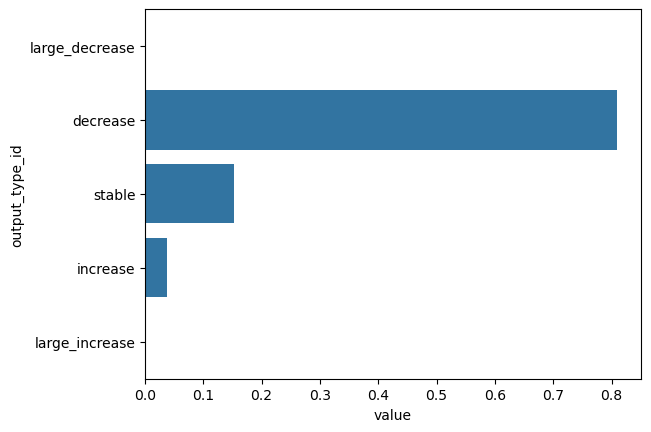

In [96]:
import seaborn as sns

df = pd.read_parquet('./data/categorical_ensemble.pq')
df = df[(df.location=='US') & (df.reference_date==df.reference_date.max()) & (df.horizon==3)]

order = ['large_decrease', 'decrease', 'stable', 'increase', 'large_increase']
# Set the column as the index, reindex with the desired order, then reset the index
df = df.set_index('output_type_id').reindex(order).reset_index()


sns.barplot(x="value", y="output_type_id", data=df)

In [93]:
df

,target_end_date,horizon,output_type_id,value,location,target,Model,output_type,reference_date
12715,2026-02-28,3,stable,0.152646,US,wk flu hosp rate change,Median Epistorm Ensemble,pmf,2026-02-07
12716,2026-02-28,3,increase,0.037228,US,wk flu hosp rate change,Median Epistorm Ensemble,pmf,2026-02-07
12717,2026-02-28,3,large_increase,0.000000,US,wk flu hosp rate change,Median Epistorm Ensemble,pmf,2026-02-07
12718,2026-02-28,3,decrease,0.810127,US,wk flu hosp rate change,Median Epistorm Ensemble,pmf,2026-02-07
12719,2026-02-28,3,large_decrease,0.000000,US,wk flu hosp rate change,Median Epistorm Ensemble,pmf,2026-02-07
